### Introduction
I am a working professional, not a professional writer. I developed this notebook to provide a "First Principles" deep dive into the underlying logic and the engineering intuition behind Self-Attention.

My goal is to go beyond the formula and explore the "Why," "What," and "How"—tracing the thought process that leads from static word embeddings to the dynamic power of the Transformer.

*Note* : The content of this notebook is a synthesis of original research papers, technical articles, and my own experience implementing these concepts from scratch to understand how we reached this point in AI.

# Self Attention

## Why 
Traditional word embeddings (like Word2Vec or GloVe) generate static embeddings. These models assign a single, fixed vector to a word regardless of how it is used. This approach captures the "average" meaning of a word across a massive dataset, but fails to account for polysemy (words with multiple meanings).


As highlighted in `Hands-on Large Language Models` by `Jay Alammar` and `Maarten Grootendorst`, consider the word "bank":
* Context A: "I sat on the river bank to fish."
* Context B: "I went to the bank to deposit money."

In a static model, "bank" has the same coordinates in both sentences. To fix this, we need dynamic embeddings that change based on the surrounding words.

## What

Self-Attention is the mechanism that allows a model to look at a sentence and decide which other words are most relevant to the current word it is processing. 

Why it is called self ??

In earlier architectures, such as `Bahdanau` or `Luong attention`, the mechanism was primarily used for sequence-to-sequence tasks like translation. In those cases, the model looked at a different sequence (the source sentence) to decide how to generate the next word in the target sequence. Self-Attention is different because, every word in the sentence "looks" at every other word in that same sentence to understand its own context.

*Don’t worry, as the discussion progresses, we’ll understand every detail that is written here.*

## Lets start from very first thought

*Question is how we do that ??*

The simplest possible answer is to consider the static embeddings of the surrounding words or the words in the sequence. By this, we mean taking a weighted sum of all the embeddings. Doing this helps us capture the dynamic meaning of a word.


*Next Question: What are these weights and how to calculate?*

One possible idea is to calculate the similarity between the main word and its surrounding or neighboring context words.
If two vectors are "similar" in vector space, they likely share a context. We can calculate this similarity using the Dot Product. The higher the dot product between two word vectors, the higher the weight we assign to that relationship.


#### Let’s Implement the "Naive" Version


So to implement this I'll be using  2 sentences

1. River bank is calm - rletaed to river bank 
2. Bank stores money - related to money bank

$$e_{bank\_new} = \sum (\text{weight}_i \times \text{embedding}_i)$$

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import math

model = SentenceTransformer("all-MiniLM-L6-v2") # this may occupy some space in local storage 

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 349.45it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [246]:
sentence1 = "River bank is calm"
sentence2 = "Bank stores money"

In [247]:
# now lets calculate the embedings of each word first  
words1 = sentence1.split()
words2 = sentence2.split()

# Get embeddings for each word
embeddings1 = {word: torch.from_numpy(model.encode(word)) for word in words1} 
embeddings2 = {word: torch.from_numpy(model.encode(word)) for word in words2}

In [249]:
embeddings1.keys()

dict_keys(['River', 'bank', 'is', 'calm'])

In [250]:
embeddings1['bank']

tensor([ 4.8726e-03,  2.5025e-02, -9.0665e-02,  9.0132e-04, -5.9366e-02,
        -7.1815e-02,  1.1657e-01,  1.4013e-02,  4.2145e-02, -5.8147e-02,
        -1.1508e-02, -4.5583e-02, -3.5099e-02, -3.5663e-02, -1.5188e-02,
        -3.6052e-02, -2.3441e-02, -7.0539e-03,  1.8166e-02,  2.3922e-03,
        -5.3348e-02, -1.4290e-02, -6.5091e-02,  7.1515e-03,  5.7892e-02,
         9.6970e-03, -1.6430e-02,  1.4969e-03, -6.2971e-02, -1.1382e-01,
         1.9664e-02,  1.9894e-02, -1.0519e-02, -5.6780e-02,  2.2164e-02,
         6.9414e-03,  3.5962e-02,  4.6325e-02,  5.9934e-02, -5.8646e-02,
        -4.9340e-02, -9.5901e-02,  3.1774e-02, -3.0073e-02,  3.2300e-02,
         5.6226e-02,  2.9741e-02,  7.2413e-02,  2.3168e-02,  8.2737e-02,
         5.1423e-02, -6.8439e-02, -2.2604e-02,  3.0447e-02, -8.4573e-03,
         4.4288e-03,  2.9056e-02,  6.0356e-03,  3.0590e-02, -6.3986e-02,
         4.4218e-02,  4.3238e-02,  9.0240e-03,  3.6717e-02,  5.6420e-02,
         5.0804e-02, -3.1154e-02,  6.0604e-02, -3.1

In [ ]:
# Now I'll calculate the dot product of all the embedings of first sentence with the word `bank` and get the score/weight 
weights1 = torch.tensor([
    torch.dot(embeddings1['bank'], embeddings1[word])
    for word in embeddings1
])

weights1

tensor([0.4996, 1.0000, 0.2495, 0.2183])

In [77]:
# To normalize the weights lets apply softmax
weights1 = torch.softmax(weights1, dim=0)
weights1

tensor([0.2391, 0.3943, 0.1862, 0.1804])

In [ ]:
# multiply these weights with embeding vectors of all the words in sentence 1
embedding_matrix = torch.stack([embeddings1[word] for word in embeddings1]) # 4*384 - coz we have 4 unique words in sent1

In [ ]:
e_bank1 = torch.matmul(weights1, embedding_matrix) # this is now new embeding of the word bank in context with sentence1

And now if we calculate the dot product of this with the word river

In [88]:
print("Old Similarity score between River and bank : ",torch.dot(embeddings1['River'],embeddings1['bank']))
print("new Similarity score between River and bank : ",torch.dot(embeddings1['River'],e_bank1))

Old Similarity score between River and bank :  tensor(0.4996)
new Similarity score between River and bank :  tensor(0.5381)


See we have increased the similarity between river and bank by doing this So The new embedding for "bank" is no longer just the dictionary definition; it is now a composite of its surroundings.

Now lets do the same for second sentence

In [ ]:
weights2 = torch.tensor([
    torch.dot(embeddings2['Bank'], embeddings2[word])
    for word in embeddings2
])
weights2 = torch.softmax(weights2, dim=0)

embedding_matrix_2 = torch.stack([embeddings2[word] for word in embeddings2]) 

e_bank2 = torch.matmul(weights2, embedding_matrix_2)

In [91]:
print("Old Similarity score between Money and bank : ",torch.dot(embeddings2['money'],embeddings2['Bank']))
print("new Similarity score between Money and bank : ",torch.dot(embeddings2['money'],e_bank2))

Old Similarity score between Money and bank :  tensor(0.4690)
new Similarity score between Money and bank :  tensor(0.5875)


### Pros
1. Contextual Awareness: Unlike Word2Vec, the embedding for a word changes based on its neighbors, successfully capturing nuances like "river bank" vs. "money bank."

2. Massive Parallelization: Unlike older RNNs (Recurrent Neural Networks) that had to process words one-by-one (left-to-right), this approach allows us to calculate the attention for every word in a sentence simultaneously. This is why Transformers are so much faster to train.

### Issues with this Approach

1. No Learnable Parameters: The major issue with this approach is that there are no learnable parameters involved. Also, using a dot product without any learned transformation is quite weak.

2. We are simply taking a weighted sum, but in a sentence where the word bank refers only related to a river, adding embeddings of all the other words introduces unnecessary and meaningless information. Therefore, we need a mechanism that can identify which words are more contextually important for the target word. This is where the Query, Key, and Value (Q, K, V) concept comes in.

### Solving the Issues: The Q, K, V Framework

Earlier, our main problem was that we didn’t know which words were important for the target word. This is where Query, Key, and Value vectors come into the picture.

##### Real life analogy :

Imagine you are searching for an answer inside a vast library:

Now you have your 

* Question - what do i have to find - Query 
* Every book have Table of content - Key
* Actual content/chapter - Value

So You take the query compare with Key and you'll get your Value. 

* Query - This is your Question. It represents what the "target word" is currently looking for to complete its meaning.
    * Example: If the word is "bank," the Query asks: "Am I looking for money or water?"
* Key - This is the Table of Contents. Every word in the sentence has a Key (index) that tells what kind of information it offers.
* Value - This is the Actual Content. Once we find a match between a Query and a Key, we extract the information stored in the Value

It essentially means: If I need information about a specific word (the event), I go to the Index (Keys) to see what kind of information is stored in every other word (the chapters). Then, based on how relevant each chapter is to my question, I fetch and combine the Relevant Content (Values) from across the entire sentence

### The Mathematical Logic
*Okay lets suppose I have the query key and value vector now what ??* 

Before moving forward, let’s first understand what the dot product actually does. It is a very interesting concept. When we compute the dot product, it helps measure the similarity between two vectors. Mathematically, it represents the cosine of the angle between the two vectors.

If you visualize this, the more the vectors point in the same direction, the higher the dot product value will be. In simple terms, it measures their alignment and relative direction.

So, if I want to find which Key (chapter) is relevant to my Query (question), I need to check which Key vector is most aligned with the Query vector. We can do this using the dot product, and the resulting value acts like an alignment or relevance score.

$$A \cdot B = \|A\| \|B\| \cos(\theta)$$



So we will do the dot product here - Q.K =  QKᵀ

$$\text{Q.K} = \text Q K^T$$



Now, this quantity is a scalar value. If you remember, earlier we performed a similar operation to obtain weights, and here we are getting something similar called the alignment score.


To convert these scores into proper weights, we apply softmax to normalize them:

$$\text{weights} = \text{softmax}(Q K^T)$$


Now, suppose the alignment score between the Query and one Key is 0.2. All we need to do next is find the Value associated with that Key (similar to the chapter content in the book analogy). If we multiply this weight or alignment score with that Value, we extract the necessary information from that Value vector (chapter) in the correct proportion.

So

$$\text{Attention} = \text{softmax}(Q K^T)V$$


Note: As you mentioned, we are missing the scaling factor ($\sqrt{d_k}$), which we will add later to prevent the scores from getting too large and "exploding."

#### Next Question: How do we find the Q, K, and V vectors?

Answer: We derive them from the original embedding vectors — which is quite intuitive.

We apply separate linear transformations to the actual static embedding vectors to obtain the Query (Q), Key (K), and Value (V) vectors.
From linear algebra, if we want to transform a vector, we multiply it by a matrix. Similarly, here we multiply the embedding vectors with three different matrices:

We introduce three separate weight matrices:\
* $W_Q$ (to create the Query)
* $W_K$ (to create the Key)
* $W_V$ (to create the Value)



Initially, these matrices are filled with random numbers. However, as the model trains on millions of sentences, it uses backpropagation to "tune" these numbers.

*By introducing these learnable transformations, we address the limitations of the earlier approach.*

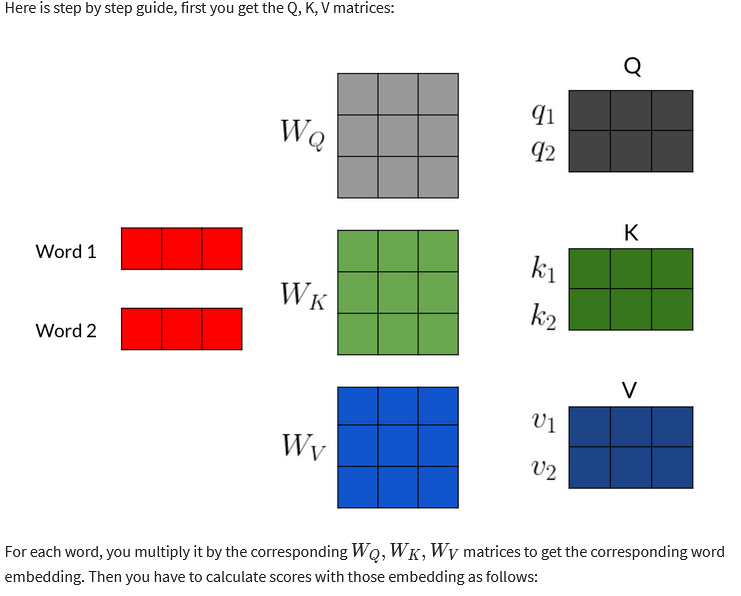

<sub>Source- https://global.discourse-cdn.com/dlai/original/3X/0/f/0fbd7acf63445ba095a0747553acf45094b5bf97.png

In [253]:
emb_size=64 # for exp puprose im taking these values small 
max_len=100 # max len of sentence 
d_k=16 # query matrix dim

In [254]:
# input static embedings
torch.manual_seed(1234)
X_e=torch.rand(max_len,emb_size) # 100x64

In [ ]:
X_e # each row represent each word/token embedings in the input sequence

tensor([[0.0290, 0.4019, 0.2598,  ..., 0.7865, 0.6604, 0.1303],
        [0.3498, 0.3824, 0.8043,  ..., 0.6084, 0.0928, 0.0719],
        [0.8733, 0.3230, 0.7917,  ..., 0.2716, 0.6552, 0.1607],
        ...,
        [0.2905, 0.0553, 0.0010,  ..., 0.7937, 0.3487, 0.2590],
        [0.5621, 0.7200, 0.5499,  ..., 0.6327, 0.5086, 0.8173],
        [0.8898, 0.4154, 0.2719,  ..., 0.5943, 0.1123, 0.5989]])

In [ ]:
# initialize Wq, Wk
Wq=torch.rand(X_e.shape[1],16) # 64x16
Wk=torch.rand(X_e.shape[1],16) # 64x16

In [129]:
Wq

tensor([[0.0205, 0.5630, 0.4293,  ..., 0.2785, 0.3916, 0.7731],
        [0.0281, 0.5611, 0.0661,  ..., 0.2974, 0.3321, 0.4877],
        [0.1331, 0.8732, 0.0491,  ..., 0.5319, 0.4574, 0.2356],
        ...,
        [0.5936, 0.3098, 0.5334,  ..., 0.6146, 0.3095, 0.3809],
        [0.4046, 0.4495, 0.9498,  ..., 0.6291, 0.7569, 0.5207],
        [0.0035, 0.1492, 0.1489,  ..., 0.5827, 0.7500, 0.2915]])

In [130]:
Wk

tensor([[0.6609, 0.0059, 0.9842,  ..., 0.8556, 0.5843, 0.6731],
        [0.6304, 0.1233, 0.8120,  ..., 0.2983, 0.9030, 0.1722],
        [0.7051, 0.1429, 0.4147,  ..., 0.1317, 0.8778, 0.0616],
        ...,
        [0.7890, 0.1071, 0.6381,  ..., 0.1173, 0.1414, 0.7371],
        [0.6424, 0.5191, 0.1879,  ..., 0.7319, 0.1453, 0.8743],
        [0.0525, 0.6639, 0.7494,  ..., 0.6045, 0.2955, 0.8793]])

In [142]:
Q=torch.matmul(X_e,Wq)
K=torch.matmul(X_e,Wk)

In [ ]:
Q # 100x64 ,each row represent Query vvector of each word/token

tensor([[16.8394, 16.2921, 17.8004,  ..., 16.0070, 15.6578, 16.0779],
        [14.3125, 15.2450, 14.3503,  ..., 14.3497, 13.9863, 15.7673],
        [17.4654, 17.4485, 17.4730,  ..., 17.2791, 17.0234, 17.5752],
        ...,
        [16.8146, 16.3030, 16.7045,  ..., 15.5876, 16.3410, 15.5301],
        [14.2034, 15.1419, 14.0014,  ..., 14.7774, 14.5103, 16.0967],
        [15.3661, 16.0101, 15.6079,  ..., 15.2012, 15.3148, 15.7524]])

In [145]:
K # 100x64

tensor([[17.6906, 13.4961, 16.2019,  ..., 17.3036, 16.2292, 15.2336],
        [16.8629, 11.8657, 14.6061,  ..., 15.0061, 16.4625, 13.6744],
        [17.8258, 12.8220, 17.2496,  ..., 18.6057, 18.7557, 15.0510],
        ...,
        [16.8779, 13.2589, 15.7190,  ..., 17.4749, 17.5593, 14.6448],
        [15.1649, 13.4474, 14.7712,  ..., 17.1644, 16.5837, 14.1124],
        [16.2785, 12.3445, 15.7707,  ..., 18.7567, 17.9281, 16.0310]])

In [ ]:
print(Q.shape)
print(K.shape) 

torch.Size([100, 16])
torch.Size([100, 16])


As we discussed next we will dot product between them 

In [ ]:
K_t=torch.transpose(K,0,1)
QK_t=torch.matmul(Q,K_t) # 100x100

In [186]:
QK_t

tensor([[4308.5503, 3963.6873, 4584.5430,  ..., 4379.5220, 4097.6665,
         4392.3979],
        [3915.1780, 3602.8042, 4165.0000,  ..., 3982.8440, 3726.8604,
         3995.8218],
        [4510.1548, 4148.1899, 4800.7500,  ..., 4587.1416, 4290.0459,
         4602.0376],
        ...,
        [4273.8047, 3929.8098, 4548.9888,  ..., 4344.5732, 4061.5977,
         4358.3506],
        [4004.4805, 3684.4038, 4262.4297,  ..., 4073.4233, 3812.7078,
         4087.3257],
        [4169.4912, 3837.8884, 4441.6230,  ..., 4243.9585, 3968.8962,
         4255.5142]])

In [149]:
QK_t.shape

torch.Size([100, 100])

#### Why divide by $\sqrt{d_k}$?
From original paper

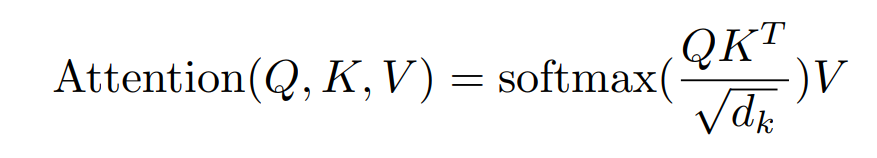

When you multiply two vectors of dimension $d_k$, the variance of their dot product grows. If $Q$ and $K$ have a mean of $0$ and a variance of $1$ (just for example), their dot product $QK^T$ will have a mean of $0$ but a variance of $d_k$.

Assume our Query ($Q$) and Key ($K$) vectors are independent random variables with a mean of 0 and a variance of 1. When we calculate the dot product $Q \cdot K = \sum_{i=1}^{d_k} q_i k_i$ :
* The variance of the product of two independent variables $q_i k_i$ is $1 \times 1 = 1$.
* Since we are summing $d_k$ such terms, the total variance of the dot product becomes:

$$\text{Var}(QK^T) = d_k$$

So by Using the Scaling Property
$$\text{Var}(aX) = a^2 \text{Var}(X)$$

If  we want to scale the variance back down to 1. If we let our scaling factor be $a = \frac{1}{\sqrt{d_k}}$, then:

$$\text{Var}\left(\frac{QK^T}{\sqrt{d_k}}\right) = \left(\frac{1}{\sqrt{d_k}}\right)^2 \times \text{Var}(QK^T)$$

$$\text{Var}\left(\frac{QK^T}{\sqrt{d_k}}\right) = \frac{1}{d_k} \times d_k = 1$$

In [256]:
print("var Q: ",torch.var(Q))
print("var K: ",torch.var(K))

var Q:  tensor(2.4833)
var K:  tensor(3.0294)


In [ ]:
print("var of dot product of Q & K: \n\n",torch.var(QK_t))
# Note here we are using random values and not proper weight initialization techniques
# A quick experiment shows that if we use random values between 0 and 1, the variance of the dot product can skyrocket to over 150,000!

var of dot product of Q & K: 

 tensor(158629.7500)


As we can see the vari of Q.K is very large 

#### Why large variance is a problem 


The problem arises with the softmax operation. When we apply softmax to values that span a large range, it tends to push the outputs toward extreme values. As a result, most values become very close to 0, while a few become very close to 1. This leads to one feature or dimension dominating the others + Vanishing Gradients, which is not desirable.

To reduce this effect, minimize variance, and stabilize the values, we introduce a scaling factor.

In [193]:
softmax_Q = torch.softmax(Q, dim=-1)
softmax_K = torch.softmax(K, dim=-1)
softmax_QK = torch.softmax(QK_t, dim=-1)

In [196]:
softmax_K

tensor([[0.1733, 0.0026, 0.0391,  ..., 0.1177, 0.0402, 0.0149],
        [0.2991, 0.0020, 0.0313,  ..., 0.0467, 0.2004, 0.0123],
        [0.0668, 0.0004, 0.0376,  ..., 0.1458, 0.1694, 0.0042],
        ...,
        [0.0714, 0.0019, 0.0224,  ..., 0.1297, 0.1411, 0.0077],
        [0.0388, 0.0070, 0.0262,  ..., 0.2865, 0.1603, 0.0135],
        [0.0262, 0.0005, 0.0158,  ..., 0.3126, 0.1365, 0.0205]])

In [197]:
softmax_QK

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

You might be able to see the issue now.

So let's calculate the final value after scalling

$$\frac{QK^T}{\sqrt{d_k}}$$

In [259]:
QK_scaled = QK_t / math.sqrt(K.shape[1])

In [260]:
QK_scaled

tensor([[1077.1376,  990.9218, 1146.1357,  ..., 1094.8805, 1024.4166,
         1098.0995],
        [ 978.7945,  900.7010, 1041.2500,  ...,  995.7110,  931.7151,
          998.9554],
        [1127.5387, 1037.0475, 1200.1875,  ..., 1146.7854, 1072.5115,
         1150.5094],
        ...,
        [1068.4512,  982.4525, 1137.2472,  ..., 1086.1433, 1015.3994,
         1089.5876],
        [1001.1201,  921.1010, 1065.6074,  ..., 1018.3558,  953.1769,
         1021.8314],
        [1042.3728,  959.4721, 1110.4058,  ..., 1060.9896,  992.2241,
         1063.8785]])

$$\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$$

In [258]:
attention_score=torch.softmax(QK_t / math.sqrt(K.shape[1]),dim=-1)

In [261]:
attention_score

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.3214e-42,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 1.4013e-45,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.6956e-43,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.0065e-45,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

The above matrix shows the attention scores across dim

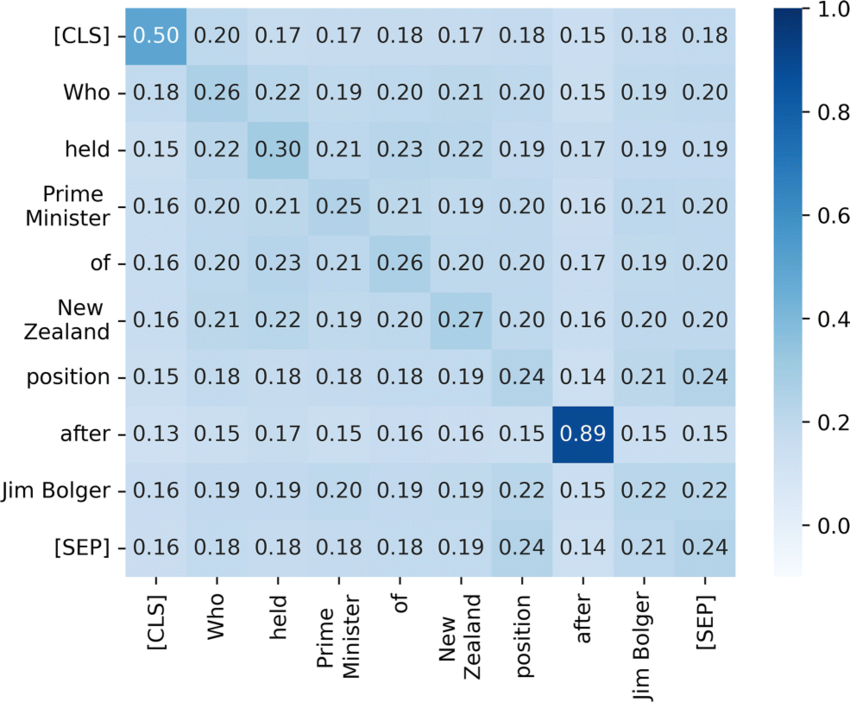

<sub> Source : https://www.researchgate.net/publication/362244918/figure/fig4/AS:11431281127078922@1678935589251/The-attention-score-matrix-of-the-question-We-use-the-question-Who-held-Prime-Minister.png

In [262]:
attention_score.shape

torch.Size([100, 100])

The Final Step: Mapping Scores to ValuesOnce we have our Attention Scores (the 100x100 matrix), we have successfully calculated "who should listen to whom." But we haven't actually updated the word's meaning yet. To do that, we need the Value ($V$) vectors.

Just like we did for Query and Key, we use a learnable weight matrix $W_V$ to project our input embeddings into the "Value" space.

Note on Dimensions: While $Q$ and $K$ must share the same dimension ($d_k$) so their dot product works, the Value vector can technically be any size. However, to keep our model consistent, we usually set the output dimension to match our input embedding size (e.g., 64).

In [266]:
Wv=torch.rand(X_e.shape[1],emb_size) 
V=torch.matmul(X_e,Wv)

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [269]:
X_e_new=torch.matmul(attention_score,V)
X_e_new # this is now contextually aware embeddings

tensor([[17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051],
        [17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051],
        [17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051],
        ...,
        [17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051],
        [17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051],
        [17.3789, 17.2561, 20.1716,  ..., 17.7423, 19.7189, 20.5051]])

### What exactly is this Output?

Each row in this final $100 \times 64$ matrix represents a word from our original sentence. But unlike the input $X_e$, these new vectors are Contextual Embeddings:
* If the word was "bank," its new vector is a weighted combination of all the values in the sentence.
* If the attention score for "river" was high ($0.8$), then $80\%$ of the "river" Value vector is now baked into the "bank" vector.

## Conclusion: 
The Full Self-Attention FormulaWe have successfully implemented the core engine of the Transformer from first principles:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

| **Step** | **Math Operation** | **Purpose** |
|----------|-------------------|-------------|
| **Linear Projection** | \( $X \cdot W_{q,k,v}$ \) | Assigns different roles to words (Query, Key, Value). |
| **Similarity Score** | \( $Q \cdot K^T$ \) | Measures how strongly words relate to each other. |
| **Scaling** | \($ \div \sqrt{d_k} $\) | Stabilizes values to prevent Softmax from producing extreme outputs. |
| **Softmax** | \($ \text{exp}(x) / \sum \text{exp}(x) $\) | Converts similarity scores into weights (probabilities). |
| **Weighted Sum** | \($ \text{Scores} \cdot V $\) | Combines contextual information into the final representation. |

